<a href="https://colab.research.google.com/github/Oreolorun/NeuralNetsPractice/blob/main/Autoencoder_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd

In [133]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#  unzipping dataset
!unzip gdrive/My\ Drive/Datasets/kagglecatsanddogs_3367a.zip > /dev/null

In [ ]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [ ]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    # self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self, rebuild=True):
    if rebuild:
      for key in self.labels:
        print(key)
        for img_file in tqdm(os.listdir(key)):
          try:
            path = os.path.join(key, img_file)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image_75 = cv2.resize(image, (75, 75)) 
            image_100 = cv2.resize(image, (100, 100))
            image_75 = np.array(image_75)
            image_100 = np.array(image_100)
            self.training_data.append([image_75, image_100])
            if key == self.sedans:
              self.sedan_count+=1
            elif key == self.coupes:
              self.coupe_count+=1
            elif key == self.suvs:
              self.suv_count+=1
            elif key == self.trucks:
              self.truck_count+=1
          except Exception as e:
            pass
      np.random.shuffle(self.training_data)
      np.save('gdrive/My Drive/Neural Networks/loaded_npy_files/upscale_data.npy', self.training_data)
      print(f'\nsedan images: {self.sedan_count}')
      print(f'coupe images: {self.coupe_count}')
      print(f'suv images: {self.suv_count}')
      print(f'truck images: {self.truck_count}')
      print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
      print('All done!')
    else:
      print('Rebuild argument set to false, data will be loaded into the dataset object from specified path. Set rebuild to true to rebuild dataset.')
      pass

In [ ]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset(rebuild=False)

#  loading dataset into object
dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/upscale_data.npy', allow_pickle=True)
print('\nDone!')

Rebuild argument set to false, data will be loaded into the dataset object from specified path. Set rebuild to true to rebuild dataset.

Done!


In [ ]:
#  upsampling images
dataset = [[cv2.resize(x[0], (100, 100), interpolation=cv2.INTER_NEAREST), x[1]] for x in dataset]
dataset = np.array(dataset)

In [ ]:
def load_out_of_sample():
  cat_imgs = []
  parent_dir = 'PetImages/Cat'

  i=0

  for file in tqdm(os.listdir(parent_dir)):
    try:
      path = os.path.join(parent_dir, file)
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, (75, 75))
      cat_imgs.append([img, 0])
      i+=1
      if i==1000:
        break
    except Exception:
      pass
  print('Done!')
  return cat_imgs

In [ ]:
def create_blur(dataset):
  """
  This function creates a dataset of
  blurred images
  """
  all_img = []
  #  looping through images and blurring
  for data in tqdm(dataset):
    blur = cv2.blur(src=data[0], ksize=(5,5))
    all_img.append([data[0], blur])
  return np.array(all_img)

In [ ]:
dataset = create_blur(dataset=dataset)
anomaly = create_blur(dataset=anomaly)

100%|██████████| 1000/1000 [00:00<00:00, 76387.85it/s]


In [ ]:
#  checking dataset
len(dataset)

81332

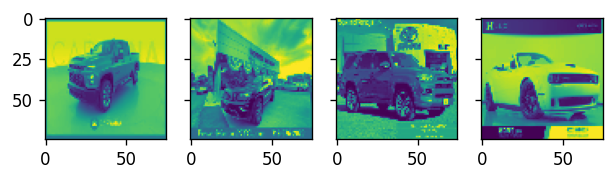

In [ ]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

In [ ]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
#test_indices, dataset_indices = train_val_split(dataset, 0.1)
#val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  saving indices for reproducbility
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', train_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', val_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', test_indices)

#  loading saved indices
train_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', allow_pickle=True))
val_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', allow_pickle=True))
test_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', allow_pickle=True))

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [ ]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    # image = image.reshape(-1, 5625) ################################
    #  extracting label from index
    label = self.loaded_dataset[idx][1]/255
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
      image = image.type(torch.float32)
      label = self.transforms(label)
      label = label.type(torch.float32)
    return (image, label)

In [ ]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())
# anomaly_ds = VehicleDataset(anomaly, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
# anomaly_dl = DataLoader(anomaly_ds, batch_size=batch_size, shuffle=True)

In [ ]:
#  building neural network
class CarRecognition(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [ ]:
#  building neural network for 75px images
class CarRecognition_75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [ ]:
#  building a convolutional autoencoder
class ConvAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    #  encoder
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128 ,3, padding=1)
    self.linear1 = nn.Linear(10368, 1500)
    #  decoder
    self.linear2 = nn.Linear(1500, 10368)
    self.conv8 = nn.ConvTranspose2d(128, 128, 3, padding=1)
    self.conv9 = nn.ConvTranspose2d(128, 128, 3, padding=1)
    self.conv10 = nn.ConvTranspose2d(128, 64, 3, padding=1)
    self.conv11 = nn.ConvTranspose2d(64, 64, 3, padding=1)
    self.conv12 = nn.ConvTranspose2d(64, 32, 3, padding=1)
    self.conv13 = nn.ConvTranspose2d(32, 32, 3, padding=1)
    self.conv14 = nn.ConvTranspose2d(32, 1, 3)
    #  pooling
    self.pool = nn.MaxPool2d(2, 2, return_indices=True)
    self.unpool = nn.MaxUnpool2d(2, 2)
    #  batchnorm
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bn6 = nn.BatchNorm2d(128)
    self.bnl1 = nn.BatchNorm1d(1500)
    self.bnl2 = nn.BatchNorm1d(10368)
    self.bn7 = nn.BatchNorm2d(128)
    self.bn8 = nn.BatchNorm2d(128)
    self.bn9 = nn.BatchNorm2d(128)
    self.bn10 = nn.BatchNorm2d(64)
    self.bn11 = nn.BatchNorm2d(64)
    self.bn12 = nn.BatchNorm2d(32)
    self.bn13 = nn.BatchNorm2d(32)

  def forward(self, x):
    x = x.view(-1, 1, 75, 75)
    x = F.relu(self.bn1(self.conv1(x)))
    size_2 = x.size()
    x, idx_2 = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = F.relu(self.bn3(self.conv3(x)))
    size_3 = x.size()
    x, idx_4 = self.pool(F.relu(self.bn4(self.conv4(x))))
    x = F.relu(self.bn5(self.conv5(x)))
    x, idx_6 = self.pool(F.relu(self.bn6(self.conv6(x))))
    x = x.view(-1, 10368)
    x = F.relu(self.bnl1(self.linear1(x)))
    x = F.relu(self.bnl2(self.linear2(x)))
    x = x.view(-1, 128, 9, 9)
    x = F.relu(self.bn8(self.conv8(x)))
    x = self.unpool(F.relu(self.bn9(self.conv9(x))), idx_6)
    x = F.relu(self.bn10(self.conv10(x)))
    x = self.unpool(F.relu(self.bn11(self.conv11(x))), idx_4, output_size=size_3)
    x = F.relu(self.bn12(self.conv12(x)))
    x = self.unpool(F.relu(self.bn13(self.conv13(x))), idx_2, output_size=size_2)
    x = self.conv14(x)
    return x[:, :, 2:, 2:]

In [ ]:
#  building a convolutional autoencoder
class ConvAutoEncoder_2(nn.Module):
  def __init__(self):
    super().__init__()
    #  encoder
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128 ,3, padding=1)
    self.linear1 = nn.Linear(10368, 500)
    #  decoder
    self.linear2 = nn.Linear(500, 10368)
    self.conv8 = nn.ConvTranspose2d(128, 128, 3, padding=1)
    self.conv9 = nn.ConvTranspose2d(128, 128, 3, padding=1)
    self.conv10 = nn.ConvTranspose2d(128, 64, 3, padding=1)
    self.conv11 = nn.ConvTranspose2d(64, 64, 3, padding=1)
    self.conv12 = nn.ConvTranspose2d(64, 32, 3, padding=1)
    self.conv13 = nn.ConvTranspose2d(32, 32, 3, padding=1)
    self.conv14 = nn.ConvTranspose2d(32, 1, 3)
    #  pooling
    self.pool = nn.MaxPool2d(2, 2, return_indices=True)
    self.unpool = nn.MaxUnpool2d(2, 2)
    
  def forward(self, x):
    x = x.view(-1, 1, 75, 75)
    x = F.relu(self.conv1(x))
    size_2 = x.size()
    x, idx_2 = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    size_3 = x.size()
    x, idx_4 = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x, idx_6 = self.pool(F.relu(self.conv6(x)))
    x = x.view(-1, 10368)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = x.view(-1, 128, 9, 9)
    x = F.relu(self.conv8(x))
    x = self.unpool(F.relu(self.conv9(x)), idx_6)
    x = F.relu(self.conv10(x))
    x = self.unpool(F.relu(self.conv11(x)), idx_4, output_size=size_3)
    x = F.relu(self.conv12(x))
    x = self.unpool(F.relu(self.conv13(x)), idx_2, output_size=size_2)
    x = self.conv14(x)
    return x[:, :, 2:, 2:]

In [ ]:
#  building a convolutional autoencoder
class ConvAutoEncoder_x(nn.Module):
  def __init__(self):
    super().__init__()
    #  encoder
    self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
    self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv5 = nn.Conv2d(16, 32, 3, padding=1)
    self.linear1 = nn.Linear(2592, 500)
    #  decoder
    self.linear2 = nn.Linear(500, 2592)
    self.conv10 = nn.ConvTranspose2d(32, 16, 3, padding=1)
    self.conv12 = nn.ConvTranspose2d(16, 8, 3, padding=1)
    self.conv14 = nn.ConvTranspose2d(8, 1, 3)
    #  pooling
    self.pool = nn.MaxPool2d(2, 2, return_indices=True)
    self.unpool = nn.MaxUnpool2d(2, 2)
    #  batchnorm
    self.bn1 = nn.BatchNorm2d(8)
    self.bn3 = nn.BatchNorm2d(16)
    self.bn5 = nn.BatchNorm2d(32)
    self.bnl1 = nn.BatchNorm1d(500)
    self.bnl2 = nn.BatchNorm1d(2592)
    self.bn10 = nn.BatchNorm2d(16)
    self.bn12 = nn.BatchNorm2d(8)

  def forward(self, x):
    #  encoder
    x = x.view(-1, 1, 75, 75)
    input_layer = x.size()
    x, idx_1 = self.pool(F.relu(self.bn1(self.conv1(x)))) # (8, 75, 75)
    #  size of layer 1
    layer_1 = x.size() # (8, 37, 37)
    x, idx_2 = self.pool(F.relu(self.bn3(self.conv3(x))))
    #  size of layer 2
    layer_2 = x.size() # (16, 18, 18)
    x, idx_3 = self.pool(F.relu(self.bn5(self.conv5(x))))
    #  size of layer 3
    layer_3 = x.size() # (32, 9, 9) 

    #  dense layers
    x = x.view(-1, 2592)
    x = F.relu(self.bnl1(self.linear1(x))) # (1, 500)
    x = F.relu(self.bnl2(self.linear2(x))) # (1, 2592)

    #  decoder
    x = x.view(-1, 32, 9, 9)
    x = F.relu(self.bn10(self.conv10(self.unpool(x, idx_3, output_size=layer_2)))) # -> (16, 18, 18) 
    x = F.relu(self.bn12(self.conv12(self.unpool(x, idx_2, output_size=layer_1)))) # -> (8, 37, 37)
    x = self.conv14(self.unpool(x, idx_1, output_size=input_layer)) # -> (1, 77, 77)
    return x[:, :, 1:-1, 1:-1]

In [ ]:
#  building a convolutional autoencoder
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 8, (3,3), padding=1)
    self.conv2 = nn.Conv2d(8, 16, (3,3), padding=1)
    self.conv3 = nn.Conv2d(16, 32, (3,3), padding=1)
    self.pool = nn.MaxPool2d((2,2))
    self.linear1 = nn.Linear(4608, 500)
    self.linear2 = nn.Linear(500, 10)

  def forward(self, x):
    x = x.view(-1, 1, 100, 100) # --> (1, 100, 100)
    # layer 1
    x = self.conv1(x)
    x = F.relu(x) # --> (8, 100, 100)

    # pooling
    x = self.pool(x) # --> (8, 50, 50)

    # layer 2
    x = self.conv2(x)
    x = F.relu(x) # --> (16, 50, 50)

    # pooling
    x = self.pool(x) # --> (16, 25, 25)

    # layer 3
    x = self.conv3(x)
    x = F.relu(x) # --> (32, 25, 25)

    # pooling
    x = self.pool(x) # --> (32, 12, 12)

    # layer 4 (linear)
    x = x.view(-1, 4608)
    x = self.linear1(x)
    x = F.relu(x) # --> (1, 500)

    #  layer 5 (linear)
    x = self.linear2(x)
    x = F.softmax(x, dim=1) # --> (1, 10)

    return x

### Upscaler

In [ ]:
class UpScaler(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(5625, 10000)
    self.conv1 = nn.Conv2d(1, 8, (3,3), padding=1)
    self.conv2 = nn.Conv2d(8, 16, (3,3), padding=1)
    self.conv3 = nn.Conv2d(16, 32, (3,3), padding=1)
    self.conv4 = nn.Conv2d(32, 64, (3,3), padding=1)
    self.conv5 = nn.Conv2d(64, 128, (3,3), padding=1)
    self.fc2 = nn.Linear(1152, 800)
    self.fc3 = nn.Linear(800, 1152)
    self.conv5T = nn.ConvTranspose2d(128, 64, (3,3), padding=1)
    self.conv4T = nn.ConvTranspose2d(64, 32, (3,3), padding=1)
    self.conv3T = nn.ConvTranspose2d(32, 16, (3,3), padding=1)
    self.conv2T = nn.ConvTranspose2d(16, 8, (3,3), padding=1)
    self.conv1T = nn.ConvTranspose2d(8, 1, (3,3), padding=1)
    self.pool = nn.MaxPool2d((2,2), return_indices=True)
    self.unpool = nn.MaxUnpool2d((2,2))
    self.bnl1 = nn.BatchNorm1d(10000)
    self.bn1 = nn.BatchNorm2d(8)
    self.bn2 = nn.BatchNorm2d(16)
    self.bn3 = nn.BatchNorm2d(32)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bnl2 = nn.BatchNorm1d(800)
    self.bnl3 = nn.BatchNorm1d(1152)
    self.bn5T = nn.BatchNorm2d(64)
    self.bn4T = nn.BatchNorm2d(32)
    self.bn3T = nn.BatchNorm2d(16)
    self.bn2T = nn.BatchNorm2d(8)

  def forward(self, x):
    # x = x.view(-1, 5625) # --> flattened vectors of size 5625
    # x = F.relu(self.bnl1(self.fc1(x))) # --> upscaled from 5625 to 10000
    # x = x.view(-1, 1, 100, 100) # --> reshaped into image of 1 channel 100x100
    x, idx_1 = self.pool(F.relu(self.bn1(self.conv1(x)))) # --> (8, 50, 50)
    layer_1 = x.size()
    x, idx_2 = self.pool(F.relu(self.bn2(self.conv2(x)))) # --> (16, 25, 25)
    layer_2 = x.size()
    x, idx_3 = self.pool(F.relu(self.bn3(self.conv3(x)))) # --> (32, 12, 12)
    layer_3 = x.size()
    x, idx_4 = self.pool(F.relu(self.bn4(self.conv4(x)))) # --> (64, 6, 6)
    layer_4 = x.size()
    x, idx_5 = self.pool(F.relu(self.bn5(self.conv5(x)))) # --> (128, 3, 3)
    layer_5 = x.size()
    # x = x.view(-1, 1152) # --> flattened vectors of size 1152
    # x = F.relu(self.bnl2(self.fc2(x))) # --> downsampled to 800
    # x = F.relu(self.bnl3(self.fc3(x))) # --> upsampled to 1152
    x = x.view(-1, 128, 3, 3) # --> reshaped into 128 channels 3x3
    x = F.relu(self.bn5T(self.conv5T(self.unpool(x, idx_5, output_size=layer_4)))) # --> (64, 6, 6)
    x = F.relu(self.bn4T(self.conv4T(self.unpool(x, idx_4, output_size=layer_3)))) # --> (32, 12, 12)
    x = F.relu(self.bn3T(self.conv3T(self.unpool(x, idx_3, output_size=layer_2)))) # --> (16, 25, 25)
    x = F.relu(self.bn2T(self.conv2T(self.unpool(x, idx_2, output_size=layer_1)))) # --> (8, 50, 50)
    x = self.conv1T(self.unpool(x, idx_1)) # --> (1, 100, 100)
    return x

In [ ]:
for img, label in train_dl:
  print(len(img))
  break

32


In [ ]:
conv_encoder = UpScaler()
conv_encoder.eval()
with torch.no_grad():
  out = conv_encoder(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


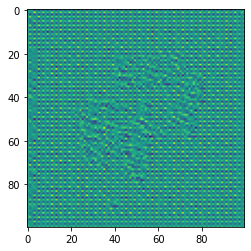

In [ ]:
plt.imshow(out[0].view(100,100))

In [ ]:
F.mse_loss(label[0], out[0])

tensor(0.2066)

### Anomaly Training loop

In [ ]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader, anomaly_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      network.train()
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()

    with torch.no_grad():
      network.eval()
      print('Deriving in-sample loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
    
    with torch.no_grad():
      network.eval()
      print('Deriving out-of-sample loss...')
      total_anomaly_loss = 0
      total_anomaly_instances = 0
      for anomaly_images, anomaly_labels in tqdm_notebook(anomaly_loader):
        #  sending to device
        anomaly_images, anomaly_labels = anomaly_images.to(device), anomaly_labels.to(device)
        #  classifying
        anomaly_outputs = network(anomaly_images)
        #  computing loss
        anomaly_loss = loss_function(anomaly_outputs, anomaly_labels)
        #  summing val_loss
        total_anomaly_loss+=anomaly_loss.sum().item()
        #  summing total_val_instances
        total_anomaly_instances+=len(anomaly_labels)
    
    metric_log.append([epoch+1, total_loss/total_instances, total_val_loss/total_val_instances])
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs} Training_loss: {round(total_loss/total_instances, 6)} In_sample_loss: {round(total_val_loss/total_val_instances, 6)} Out_of_sample_loss: {round(total_anomaly_loss/total_anomaly_instances, 6)}')
  np.save(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/dud.npy', metric_log)

### Training Loop

In [ ]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      network.train()
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()

    with torch.no_grad():
      network.eval()
      print('Deriving in-sample loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
    
    #  appending to log
    metric_log.append([epoch+1, total_loss/total_instances, total_val_loss/total_val_instances])

    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs} Training_loss: {round(total_loss/total_instances, 6)} Validation_loss: {round(total_val_loss/total_val_instances, 6)}')
  return metric_log  

In [ ]:
model = UpScaler()
model.to(device)

In [ ]:


loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

metrics = train_model(network=model, epochs=epochs, loss_function=loss_fn, 
                      opt=optimizer, train_loader=train_dl, val_loader=val_dl)


Training Epoch 1/5


  0%|          | 0/1830 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Deriving in-sample loss...


  0%|          | 0/458 [00:00<?, ?it/s]

Epoch: 1/5 Training_loss: 0.000321 Validation_loss: 0.000309

Training Epoch 2/5


  0%|          | 0/1830 [00:00<?, ?it/s]

Deriving in-sample loss...


  0%|          | 0/458 [00:00<?, ?it/s]

Epoch: 2/5 Training_loss: 0.000314 Validation_loss: 0.000303

Training Epoch 3/5


  0%|          | 0/1830 [00:00<?, ?it/s]

Deriving in-sample loss...


  0%|          | 0/458 [00:00<?, ?it/s]

Epoch: 3/5 Training_loss: 0.000309 Validation_loss: 0.0003

Training Epoch 4/5


  0%|          | 0/1830 [00:00<?, ?it/s]

Deriving in-sample loss...


  0%|          | 0/458 [00:00<?, ?it/s]

Epoch: 4/5 Training_loss: 0.000305 Validation_loss: 0.000298

Training Epoch 5/5


  0%|          | 0/1830 [00:00<?, ?it/s]

Deriving in-sample loss...


  0%|          | 0/458 [00:00<?, ?it/s]

Epoch: 5/5 Training_loss: 0.000303 Validation_loss: 0.000299


In [ ]:
for img, lb in test_dl:
  print(len(img))
  break

32


In [ ]:
model.eval()
with torch.no_grad():
  out = model(img.to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
F.mse_loss(out[0].cpu(), lb[0])

tensor(0.0060)

In [ ]:
def plot_upscaled(idx):
  loss = F.mse_loss(out[idx].cpu(), lb[idx])
  print(f'loss = {round(loss.item(),3)}')
  fig, axes = plt.subplots(1, 2, dpi=100)
  axes[0].imshow(out[idx].cpu().view(100,100), cmap='gray')
  axes[1].imshow(lb[idx].cpu().view(100,100), cmap='gray')
  pass

loss = 0.012


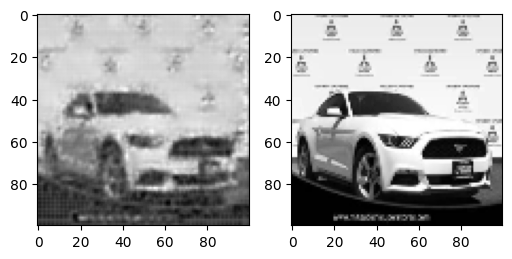

In [ ]:
plot_upscaled(5)

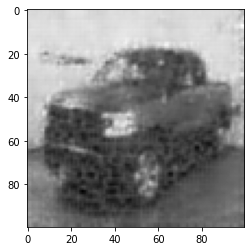

In [ ]:
plt.imshow(out[3].cpu().view(100, 100), cmap='gray')

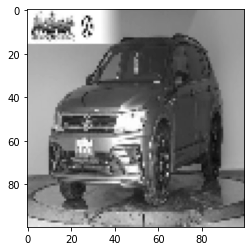

In [ ]:
plt.imshow(lb[3].view(100, 100), cmap='gray')

In [ ]:
#  saving model state
torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/car_convencoder_model_state.pt')

In [ ]:
#  loading autoencoder
autoencoder = ConvAutoEncoder()
autoencoder.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/car_convencoder_model_state.pt', map_location=device))

<All keys matched successfully>

In [ ]:
def test_encoder(path, encoder):
  encoder.eval()
  with torch.no_grad():
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (75, 75))
    # image = cv2.blur(src=image, ksize=(5,5))
    # image = image.reshape(1, 5625)
    image = transforms.ToTensor()(image)
    image = image.type(torch.float32).to(device)
    out = encoder(image)
    mse = F.mse_loss(image.view(1, 75, 75), out.view(1, 75, 75))
    print(f'MSE: {round(mse.item(), 4)}')
    #  plotting
    fig, axes = plt.subplots(1, 2, dpi=120, sharey=True)
    axes[0].imshow(image.cpu().view(75, 75), cmap='gray')
    axes[1].imshow(out.cpu().view(75, 75), cmap='gray')
    pass

MSE: 0.0337


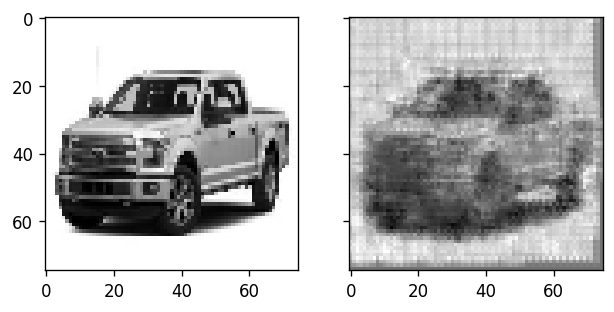

In [ ]:
test_encoder('trk_28.jpg', model)

### Visual Similarity

In [ ]:
#  building neural network (100px with batchnorm)
class CarRecognition_bn100(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    return x

In [ ]:
#  building neural network (100px with batchnorm)
class CarRecognition_100(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = self.fc1(x)
    return x

In [ ]:
import shutil
import pickle

In [ ]:
def load_filenames():
  dir =  {
          'sedan': 'gdrive/My Drive/Datasets/Car_Images/sedans',
          'coupe': 'gdrive/My Drive/Datasets/Car_Images/coupes',
          'suv': 'gdrive/My Drive/Datasets/Car_Images/suvs',
          'truck': 'gdrive/My Drive/Datasets/Car_Images/trucks'
          }

  all_files = []
  selected_files = []
  loaded_images = []

  print('deriving filenames')
  for key, value in tqdm(dir.items()):
    files = os.listdir(value)
    all_files.append(files)

  print('selecting random files')
  for file_list in tqdm(all_files):
    np.random.shuffle(file_list)
    selected = file_list[:2000]
    selected_files.extend(selected)

  print('loading images')
  for f in tqdm(selected_files):
    #  deriving filepath
    if 'sedan' in f:
      path = os.path.join(dir['sedan'], f)
    elif 'coupe' in f:
      path = os.path.join(dir['coupe'], f)
    elif 'suv' in f:
      path = os.path.join(dir['suv'], f)
    elif 'truck' in f:
      path = os.path.join(dir['truck'], f)

    #  loading image
    try:
      image = cv2.imread(path)
      image = cv2.resize(image, (100, 100))
    except Exception:
      pass
    
    #  saving to list
    loaded_images.append([image, f])

  return loaded_images

In [ ]:
files = load_filenames()
files = [x for x in files if x[0] is not None]

deriving filenames


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


selecting random files


100%|██████████| 4/4 [00:00<00:00, 208.58it/s]


loading images


100%|██████████| 8000/8000 [18:51<00:00,  7.07it/s]


In [ ]:
#  saving image arrays
with open('gdrive/My Drive/Datasets/similarity_images.pkl', 'wb') as f:
  pickle.dump(files, f)

In [ ]:
with open('gdrive/My Drive/Datasets/similarity_images.pkl', 'rb') as f:
  files = pickle.load(f)

In [ ]:
#  extracting filenames
filenames = [x[1] for x in files]

In [ ]:
def derive_filepaths(file_list):
  dir =  {
          'sedan': 'gdrive/My Drive/Datasets/Car_Images/sedans',
          'coupe': 'gdrive/My Drive/Datasets/Car_Images/coupes',
          'suv': 'gdrive/My Drive/Datasets/Car_Images/suvs',
          'truck': 'gdrive/My Drive/Datasets/Car_Images/trucks'
          }

  all = []

  for f in tqdm(file_list):
    #  deriving filepath
    if 'sedan' in f:
      path = os.path.join(dir['sedan'], f)
    elif 'coupe' in f:
      path = os.path.join(dir['coupe'], f)
    elif 'suv' in f:
      path = os.path.join(dir['suv'], f)
    elif 'truck' in f:
      path = os.path.join(dir['truck'], f)
  
    all.append(path)
  return all

In [ ]:
filepaths = derive_filepaths(filenames)

100%|██████████| 8000/8000 [00:00<00:00, 294735.27it/s]


In [ ]:
filepaths[0]

'gdrive/My Drive/Datasets/Car_Images/sedans/sedan_38776.jpg'

In [ ]:
destination = 'gdrive/My Drive/Datasets/Car_Images/similarity_images'

#  copying images
for i in tqdm(range(len(filepaths))):
  shutil.copy(filepaths[i], destination)

len(os.listdir('gdrive/My Drive/Datasets/Car_Images/similarity_images'))

100%|██████████| 8000/8000 [01:32<00:00, 86.03it/s]


8000

In [ ]:
files_x = files[:]

In [ ]:
#  preprocessing image arrays into tensors
files = [[img/255, f] for img, f in files]
files = [[transforms.ToTensor()(img), f] for img, f in files]

In [ ]:
#  loading model state
model = CarRecognition_bn100()
model.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100_model_state_1e-2_9ep.pt', map_location=device))

<All keys matched successfully>

In [ ]:
#  processing image
img = cv2.imread('trk_28.jpg')
img = cv2.resize(img, (100, 100))
img = img/255
img = transforms.ToTensor()(img)

In [ ]:
#  extracting features
model.eval()
with torch.no_grad():
  files = [[model(img), f] for img, f in tqdm(files)]

100%|██████████| 8000/8000 [02:55<00:00, 45.54it/s]


In [ ]:
with open('gdrive/My Drive/Datasets/similarity_features.pkl', 'wb') as f:
  pickle.dump(files, f)

In [ ]:
with open('gdrive/My Drive/Datasets/similarity_features.pkl', 'rb') as f:
  eggs = pickle.load(f)

In [ ]:
F.cosine_similarity(files[1][0], files[670][0])

tensor([0.5330])

In [ ]:
similarity = [[F.cosine_similarity(files[4879][0], img).item(), f] for img, f in tqdm(files)]

100%|██████████| 8000/8000 [00:00<00:00, 16372.90it/s]


In [ ]:
scores = [x[0] for x in similarity]
f_names = [x[1] for x in similarity]

sr = pd.Series(scores, index=f_names)
sr = sr.sort_values(ascending=False)
sr.head(10)

suv_1101.jpg     1.000000
suv_10223.jpg    0.845531
suv_7371.jpg     0.804062
suv_59839.jpg    0.794439
suv_835.jpg      0.784851
suv_13946.jpg    0.754294
suv_64347.jpg    0.752008
suv_55795.jpg    0.748010
suv_12578.jpg    0.747605
suv_52711.jpg    0.745200
dtype: float64

In [ ]:
files[670][1]

'sedan_12508.jpg'

In [ ]:
model.eval()
with torch.no_grad():
  output = model(files[1][0])

In [145]:
def enlarge(img):
  """
  This function enlarges an image
  """
  #  reading image
  image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (75, 75))
  original_image = image[:]
  
  #  creating array of zeros
  zeros = np.zeros(75)
  #  inserting into image x-axis
  for i in range(4, 100, 4):
    image = np.insert(image, i, zeros, axis=1)

  #  creating array of zeros
  zeros = np.zeros(99)
  #  inserting into image y-axis
  for i in range(4, 100, 4):
    image = np.insert(image, i, zeros, axis=0)

  #  creating image copy
  upscaled = image.copy()

  #  computing linear interpolation
  try:
    for i in tqdm(range(100)):
      for j in range(4, 100, 4):
        upscaled[i, j] = (upscaled[i, j-1]/2) + (upscaled[i, j+1]/2)
  except Exception:
    pass

  try:
    for i in tqdm(range(100)):
      for j in range(4, 100, 4):
        upscaled[:, i][j] = (upscaled[:, i][j-1]/2) + (upscaled[:, i][j+1]/2)
  except Exception:
    pass

  #  printing upscaled image
  fig, axes = plt.subplots(1, 2, dpi=120)
  #axes[0].imshow(original_image)
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('zeros_inserted')
  axes[1].imshow(upscaled, cmap='gray')
  axes[1].set_title('enlarged')
  pass

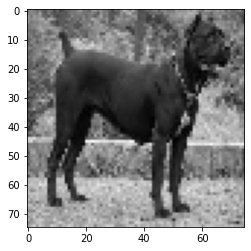

In [135]:
im = cv2.imread('sample_4.jpg', cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im, (75,75))
plt.imshow(im, cmap='gray')
plt.savefig('gdrive/My Drive/Datasets/plt_plots/inter_original.png', dpi=1000)

 99%|█████████▉| 99/100 [00:00<00:00, 5161.10it/s]


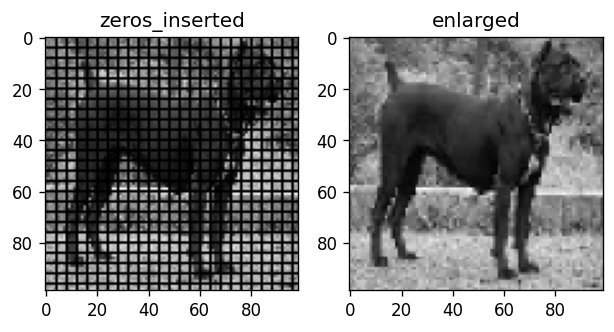

In [146]:
enlarge('sample_4.jpg')
#plt.savefig('gdrive/My Drive/Datasets/plt_plots/inter_enlarged.png', dpi=1000)

In [77]:
zero = np.zeros(75)
ones = np.ones((75,75))

In [78]:
for j in range(4, 100, 4):
  ones = np.insert(ones, j, zero, axis=0)

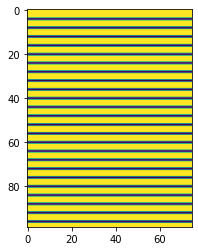

In [79]:
plt.imshow(ones)

In [118]:
ones[:, 0][4]

0.0

### Redundant

In [ ]:
#  defining visual test function
def visual_test(path, model_1, model_2):
  with torch.no_grad():
    vt_img = cv2.imread(path)
    vt_img = cv2.resize(vt_img, (75,75))
    vt_img_tensor = transforms.ToTensor()(vt_img)
    out = model_1(vt_img_tensor)
    output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
    probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
    print('model 75x75px')
    print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
          +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
    print(f'prediction: {output_dict[torch.argmax(out).item()]}')
    print('_'*55)

    vt_img = cv2.imread(path)
    vt_img = cv2.resize(vt_img, (100,100))
    plt.imshow(vt_img)
    vt_img_tensor = transforms.ToTensor()(vt_img)
    out = model_2(vt_img_tensor)
    output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
    probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
    print('model 100x100px')
    print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
          +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
    print(f'prediction: {output_dict[torch.argmax(out).item()]}')
    print('_'*55)

    print('average class prediction')
    avg = np.array(([probability.numpy()], [probability_2.numpy()]))
    avg = avg.reshape(2,4)
    avg = avg.mean(axis=0)
    print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
          +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
    print(f'prediction: {output_dict[np.argmax(avg)]}')
    print('_'*55)

    print('highest confidence')
    confidence =  torch.concat((probability, probability_2), dim=1)
    highest_conf = torch.argmax(confidence)
    out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                   4:'sedan', 5:'coupe', 6:'suv', 7:'truck'}
    print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
          +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
          +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
          +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%')
    print(f'prediction: {out_hc_dict[highest_conf.item()]}') 

model 75x75px
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
model 100x100px
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
highest confidence
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
prediction: sedan


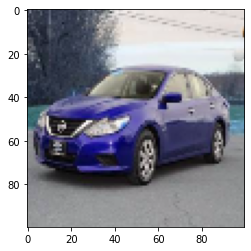

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sdn_21.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 44.0%, coupe: 20.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
model 100x100px
sedan: 26.0%, coupe: 36.0%, suv: 19.0%, truck: 19.0%
prediction: coupe
_______________________________________________________
average class prediction
sedan: 35.0%, coupe: 28.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
highest confidence
sedan: 44.0%, coupe: 20.0%, suv: 18.0%, truck: 18.0%
sedan: 26.0%, coupe: 36.0%, suv: 19.0%, truck: 19.0%
prediction: sedan


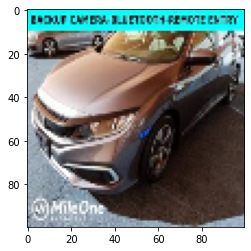

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sdn_31.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 26.0%, coupe: 37.0%, suv: 19.0%, truck: 19.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
average class prediction
sedan: 22.0%, coupe: 42.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 26.0%, coupe: 37.0%, suv: 19.0%, truck: 19.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe


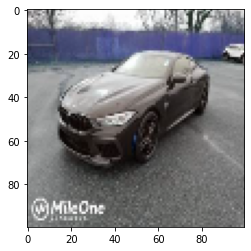

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/cup_11.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 19.0%, coupe: 46.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 40.0%, coupe: 22.0%, suv: 20.0%, truck: 19.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 29.0%, coupe: 34.0%, suv: 19.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 19.0%, coupe: 46.0%, suv: 18.0%, truck: 18.0%
sedan: 40.0%, coupe: 22.0%, suv: 20.0%, truck: 19.0%
prediction: coupe


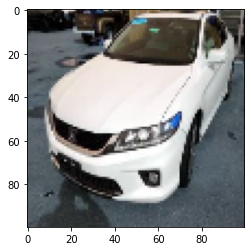

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/cup_26.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 18.0%, suv: 46.0%, truck: 18.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 18.0%, suv: 47.0%, truck: 18.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 18.0%, coupe: 18.0%, suv: 46.0%, truck: 18.0%
prediction: suv


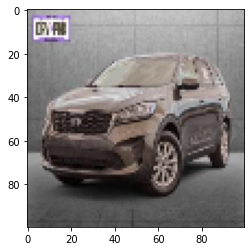

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sv_27.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 36.0%, coupe: 20.0%, suv: 21.0%, truck: 24.0%
prediction: sedan
_______________________________________________________
model 100x100px
sedan: 19.0%, coupe: 19.0%, suv: 37.0%, truck: 25.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 27.0%, coupe: 19.0%, suv: 29.0%, truck: 24.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 36.0%, coupe: 20.0%, suv: 21.0%, truck: 24.0%
sedan: 19.0%, coupe: 19.0%, suv: 37.0%, truck: 25.0%
prediction: suv


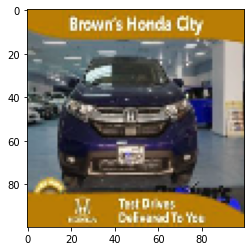

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sv_3.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
prediction: truck
_______________________________________________________
model 100x100px
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
prediction: truck
_______________________________________________________
average class prediction
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
prediction: truck
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
prediction: truck


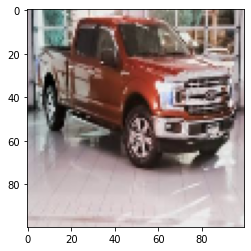

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/trk_11.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 19.0%, coupe: 19.0%, suv: 34.0%, truck: 28.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 18.0%, suv: 18.0%, truck: 46.0%
prediction: truck
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 18.0%, suv: 26.0%, truck: 37.0%
prediction: truck
_______________________________________________________
highest confidence
sedan: 19.0%, coupe: 19.0%, suv: 34.0%, truck: 28.0%
sedan: 18.0%, coupe: 18.0%, suv: 18.0%, truck: 46.0%
prediction: truck


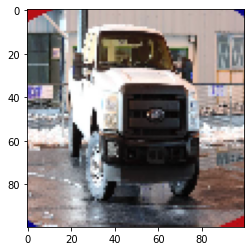

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/trk_31.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 20.0%, coupe: 39.0%, suv: 19.0%, truck: 23.0%
prediction: coupe
_______________________________________________________
average class prediction
sedan: 19.0%, coupe: 43.0%, suv: 18.0%, truck: 20.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
sedan: 20.0%, coupe: 39.0%, suv: 19.0%, truck: 23.0%
prediction: coupe


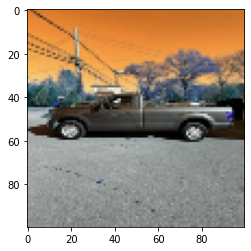

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/trk_13.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

model 75x75px
sedan: 21.0%, coupe: 24.0%, suv: 27.0%, truck: 28.0%
prediction: truck
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
average class prediction
sedan: 19.0%, coupe: 36.0%, suv: 22.0%, truck: 23.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 21.0%, coupe: 24.0%, suv: 27.0%, truck: 28.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe


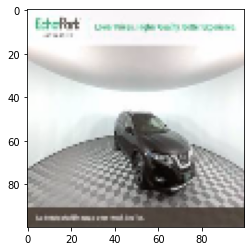

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/sv_24.jpg'

#  performing visual test
visual_test(path, model_75, model_100)

In [ ]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([5,6,7,8])
c = np.array(([a.numpy()],[b.numpy()]))

torch.concat((a,b), dim=0)[4]

tensor(5)

In [ ]:
torch.concat((probability, probability_2), dim=0)

NameError: ignored

In [ ]:
c = c.reshape(2,4)
np.argmax(c.mean(axis=0))

3

In [ ]:
#  deriving test accuracy
accuracy(model, test_dl, verbose=True)

  0%|          | 0/41 [00:00<?, ?it/s]

model predicts all instances to 95.94% accuracy


In [ ]:
def extract_results(network, dataloader, file_name):
  #  creating an empty list
  results = []
  labels = []
  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      img, lb = img.to(device), lb.to(device)
      preds = network(img)
      results.extend(torch.argmax(preds, dim=1).tolist())
      labels.extend(lb.tolist())
  df = pd.DataFrame({'predicted': results, 'labels': labels})
  df.to_csv(f'gdrive/My Drive/Neural Networks/Test_results/{file_name}', index=False)
  print('Done!')
  return df.head()

In [ ]:
#  extracting test results
extract_results(model, test_dl, 'CarType100x100_results.csv')

100%|██████████| 41/41 [00:08<00:00,  4.86it/s]


Done!


,predicted,labels
0,3,3
1,0,0
2,0,0
3,2,2
4,1,1


In [ ]:
#  loading test results
test_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100x100_results.csv')

In [ ]:
#  total number of instances
len(test_results)

8133

In [ ]:
#  preview of test results
test_results.head()

,predicted,labels
0,3,3
1,0,0
2,0,0
3,2,2
4,1,1


In [ ]:
#  defining mapping function
def actual_label(instance):
  if instance == 0:
    instance = 'sedan'
  elif instance == 1:
    instance = 'coupe'
  elif instance == 2:
    instance = 'suv'
  elif instance == 3:
    instance = 'truck'
  return instance

In [ ]:
#  converting numerical labels into strings
test_results['predicted'] = test_results['predicted'].map(actual_label)
test_results['labels'] = test_results['labels'].map(actual_label) 

In [ ]:
#  previewing converted labels
test_results.head()

,predicted,labels
0,truck,truck
1,sedan,sedan
2,sedan,sedan
3,suv,suv
4,coupe,coupe


In [ ]:
#  filtering out misclassified instances
misclassified = test_results[test_results['predicted']!=test_results['labels']]
misclassified.head()

,predicted,labels
8,coupe,sedan
11,coupe,sedan
51,sedan,coupe
63,coupe,sedan
77,coupe,sedan


In [ ]:
#  number of misclassified instances
len(misclassified)

330

In [ ]:
#  distribution of misclassified instances by true class
misclassified['labels'].value_counts()

sedan    147
coupe     88
suv       55
truck     40
Name: labels, dtype: int64

In [ ]:
#  distribution of misclassified sedans by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='sedan']
misclassified_sedan['predicted'].value_counts()

coupe    105
suv       40
truck      2
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified suvs by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='suv']
misclassified_sedan['predicted'].value_counts()

sedan    24
truck    20
coupe    11
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified coupes by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='coupe']
misclassified_sedan['predicted'].value_counts()

sedan    69
suv      14
truck     5
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified trucks by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='truck']
misclassified_sedan['predicted'].value_counts()

suv      26
coupe    11
sedan     3
Name: predicted, dtype: int64